<h2>ShakespeareGPT</h2>

In [2]:
import torch
import ipdb
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import re

torch.set_num_threads(4)
torch.set_printoptions(precision=7, sci_mode=False)
torch.manual_seed(42128)
gen = torch.Generator().manual_seed(42128)
gen

In [3]:
text = open("input.txt", 'r', encoding="utf-8").read()
special_charas = ['$', '&', '3', '-', ';']

# Create a regex pattern to match the special characters
pattern = re.compile(f"[{re.escape(''.join(special_charas))}]")

# Remove the special characters
text = pattern.sub('', text)
text[:500]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor "

In [4]:
len(text)

1119738

In [5]:
chara_list = sorted(set(text))
vocab_size = len(chara_list)
chara_list, vocab_size

(['\n',
  ' ',
  '!',
  "'",
  ',',
  '.',
  ':',
  '?',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z'],
 60)

In [6]:
encoding = {s:i for i, s in enumerate(chara_list)}
decoding = {i:s for i, s in enumerate(chara_list)}
encoding, decoding

({'\n': 0,
  ' ': 1,
  '!': 2,
  "'": 3,
  ',': 4,
  '.': 5,
  ':': 6,
  '?': 7,
  'A': 8,
  'B': 9,
  'C': 10,
  'D': 11,
  'E': 12,
  'F': 13,
  'G': 14,
  'H': 15,
  'I': 16,
  'J': 17,
  'K': 18,
  'L': 19,
  'M': 20,
  'N': 21,
  'O': 22,
  'P': 23,
  'Q': 24,
  'R': 25,
  'S': 26,
  'T': 27,
  'U': 28,
  'V': 29,
  'W': 30,
  'X': 31,
  'Y': 32,
  'Z': 33,
  'a': 34,
  'b': 35,
  'c': 36,
  'd': 37,
  'e': 38,
  'f': 39,
  'g': 40,
  'h': 41,
  'i': 42,
  'j': 43,
  'k': 44,
  'l': 45,
  'm': 46,
  'n': 47,
  'o': 48,
  'p': 49,
  'q': 50,
  'r': 51,
  's': 52,
  't': 53,
  'u': 54,
  'v': 55,
  'w': 56,
  'x': 57,
  'y': 58,
  'z': 59},
 {0: '\n',
  1: ' ',
  2: '!',
  3: "'",
  4: ',',
  5: '.',
  6: ':',
  7: '?',
  8: 'A',
  9: 'B',
  10: 'C',
  11: 'D',
  12: 'E',
  13: 'F',
  14: 'G',
  15: 'H',
  16: 'I',
  17: 'J',
  18: 'K',
  19: 'L',
  20: 'M',
  21: 'N',
  22: 'O',
  23: 'P',
  24: 'Q',
  25: 'R',
  26: 'S',
  27: 'T',
  28: 'U',
  29: 'V',
  30: 'W',
  31: 'X',
  32:

In [7]:
encode = lambda seq: [encoding[letter] for letter in seq]
decode = lambda tensor: [''.join(decoding[integer] for integer in tensor)]
#encode('hi'), decode([47,38])

In [8]:
data = torch.tensor(encode(text), dtype=torch.long)
data[:100], data.dtype, data.shape[0]

(tensor([13, 42, 51, 52, 53,  1, 10, 42, 53, 42, 59, 38, 47,  6,  0,  9, 38, 39,
         48, 51, 38,  1, 56, 38,  1, 49, 51, 48, 36, 38, 38, 37,  1, 34, 47, 58,
          1, 39, 54, 51, 53, 41, 38, 51,  4,  1, 41, 38, 34, 51,  1, 46, 38,  1,
         52, 49, 38, 34, 44,  5,  0,  0,  8, 45, 45,  6,  0, 26, 49, 38, 34, 44,
          4,  1, 52, 49, 38, 34, 44,  5,  0,  0, 13, 42, 51, 52, 53,  1, 10, 42,
         53, 42, 59, 38, 47,  6,  0, 32, 48, 54]),
 torch.int64,
 1119738)

In [9]:
n = int(0.9 * len(data))
train, val = data[:n], data[n:]

In [10]:
batch_size = 5
block_size = 128

def get_batch(split):
    data = train if split == " train" else val
    idx = torch.randint(0, data.shape[0] - block_size, (batch_size, ))
    x = torch.stack([data[i:i+block_size] for i in idx ])
    y = torch.stack([data[i+1:i+block_size+1] for i in idx])
    return x,y

x_batch, y_batch = get_batch("train")
x_batch.shape, y_batch.shape

(torch.Size([5, 128]), torch.Size([5, 128]))

In [11]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones((block_size, block_size))))

    def forward(self, x):
        batch, context, head = x.shape
        key_vector = self.key(x)
        query_vector = self.query(x)
        value_vector = self.value(x)
        
        # compute attention scores(affinities)
        weights = query_vector @ key_vector.transpose(-2, -1) * head**-0.5
        # mask values
        weights = weights.masked_fill(self.tril == 0, -torch.inf)
        weights = F.softmax(weights, dim=-1)
        out = weights @ value_vector
        return out 

In [12]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        self.out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.out

In [13]:
class Feed_Forward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),      # projection layer, residual connection
            nn.Dropout(0.2),
        )

    def forward(self, x):
        self.out = self.net(x)
        return self.out

<h3>Layer Norm</h3><br>

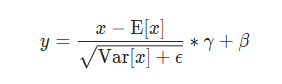

In [14]:
class LayerNorm(nn.Module):
    def __init__(self, dim, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def forward(self, x):
        x_mean = x.mean(dim=1, keepdim=True)
        x_var = x.var(dim=1, keepdim=True)
        x_hat = (x - x_mean) / (torch.sqrt(x_var + self.epsilon))
        self.out = x_hat * self.gamma + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [15]:
class Transformer_block(nn.Module):
    def __init__(self, n_embed, num_heads):
        super().__init__()
        head_size = n_embed // num_heads
        self.attention = Multi_Head_Attention(num_heads, head_size)
        self.feed_fwd = Feed_Forward(n_embed)
        self.layer_norm1 = LayerNorm(n_embed)
        self.layer_norm2 = LayerNorm(n_embed)

    def forward(self, x):
        x = self.attention(self.layer_norm1(x))  # normalize inputs before sending to attention (not in paper)
        x = self.feed_fwd(self.layer_norm2(x))    # normalize inputs before sending to MLP (not in paper)
        return x

In [16]:
n_embed = 64  # number of embeddings per vector

class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, n_embed)
        self.position_embedding = nn.Embedding(block_size, n_embed)
        self.transformer_layers = nn.Sequential(
            Transformer_block(n_embed, 2),
            Transformer_block(n_embed, 2),
            nn.Dropout(0.2)
            )
        self.lang_model_head = nn.Linear(n_embed, vocab_size)
        

    def forward(self, idx, targets=None):
        B, T = idx.shape
        token_emb = self.token_embeddings(idx) # shape = batch, context, n_embed
        pos_emb = self.position_embedding(torch.arange(T)) # shape = T, n_embed
        x = token_emb + pos_emb
        x = self.transformer_layers(x)
        logits = self.lang_model_head(x) # shape = batch, context, vocab_size
        
        if targets is None:
            loss = None       # while sampling
        else:
            batch, context, chara_probs = logits.shape
            logits = logits.view(batch * context, chara_probs)
            targets = targets.view(batch * context)
            
            loss = F.cross_entropy(logits, targets)
            
        return logits, loss
        

    def sample(self, idx, max_new_tokens):
        # idx = context sequence
        for _ in range(max_new_tokens):
            idx_cond =  idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]  # focus on most recent char, shape = (batch, chara_probs=65)
            probs = F.softmax(logits, dim=1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1) # shape = (batch, context+1)
            
        return idx

In [17]:
from torchinfo import summary
model=BigramLanguageModel()
summary(model,col_names=["trainable"],input_data=x_batch)

Layer (type:depth-idx)                        Trainable
BigramLanguageModel                           True
├─Embedding: 1-1                              True
├─Embedding: 1-2                              True
├─Sequential: 1-3                             True
│    └─Transformer_block: 2-1                 True
│    │    └─LayerNorm: 3-1                    --
│    │    └─Multi_Head_Attention: 3-2         True
│    │    └─LayerNorm: 3-3                    --
│    │    └─Feed_Forward: 3-4                 True
│    └─Transformer_block: 2-2                 True
│    │    └─LayerNorm: 3-5                    --
│    │    └─Multi_Head_Attention: 3-6         True
│    │    └─LayerNorm: 3-7                    --
│    │    └─Feed_Forward: 3-8                 True
│    └─Dropout: 2-3                           --
│    └─Transformer_block: 2-4                 True
│    │    └─LayerNorm: 3-9                    --
│    │    └─Multi_Head_Attention: 3-10        True
│    │    └─LayerNorm: 3-11           

In [17]:
# calculate loss using random samples in train and val set
@torch.no_grad()
def eval_loss(model, k_evals=200):
    """
    
    model: pass model
    k_evals: number of samples i wanna evaluate. final loss = mean(losses)
    .
    """
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(k_evals)
        for k in range(k_evals):
            x, y = get_batch(split)
            logits, loss = model(x, y)
            losses[k] = loss
        out[split] = losses.mean()
        
    model.train()
    return out

In [19]:
m = BigramLanguageModel()
logits, loss = m(x_batch, y_batch)
param_count = sum(p.numel() for p in m.parameters())

logits, loss, param_count

(tensor([[-0.8321975,  1.5294248, -0.0498837,  ...,  5.5097656, -3.4576488,
           2.2139833],
         [-3.8014920, -1.3549232, -3.6043174,  ...,  5.0738444, -0.5213884,
           2.3523982],
         [-1.7608663,  0.9405650,  0.3027689,  ...,  3.0518680,  1.1503776,
           4.4665322],
         ...,
         [-0.3264793, -0.3572777, -0.6178424,  ...,  0.3021757, -0.3449218,
           0.2438089],
         [-0.4029801, -0.4703414, -0.0177950,  ..., -0.1167469, -0.4593930,
          -0.2783322],
         [-0.2493284, -0.1862219, -0.0907258,  ..., -0.1385843, -0.4597508,
          -0.6296268]], grad_fn=<ViewBackward0>),
 tensor(4.2914295, grad_fn=<NllLossBackward0>),
 106684)

In [29]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [31]:
batch_size = 64
iterations = 500

for i in range(iterations):
    xb, yb = get_batch("train")

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if i%50 == 0 or i == iterations-1:
        losses = eval_loss(m)
        print(f"iter {i} \t | train_loss = {losses['train']} \t| val_loss = {losses['val']}")

iter 0 	 | train_loss = 1.8804755210876465 	| val_loss = 1.880314826965332
iter 50 	 | train_loss = 1.8941513299942017 	| val_loss = 1.8909765481948853
iter 100 	 | train_loss = 1.8774014711380005 	| val_loss = 1.878806710243225
iter 150 	 | train_loss = 1.8589909076690674 	| val_loss = 1.8590350151062012
iter 200 	 | train_loss = 1.8615782260894775 	| val_loss = 1.8597813844680786
iter 250 	 | train_loss = 1.8253178596496582 	| val_loss = 1.8259752988815308
iter 300 	 | train_loss = 1.819313406944275 	| val_loss = 1.8235676288604736
iter 350 	 | train_loss = 1.8168867826461792 	| val_loss = 1.8146950006484985
iter 400 	 | train_loss = 1.7982231378555298 	| val_loss = 1.7990293502807617
iter 450 	 | train_loss = 1.7824065685272217 	| val_loss = 1.781734824180603
iter 499 	 | train_loss = 1.7713607549667358 	| val_loss = 1.7716691493988037


In [ ]:




















start_idx = torch.zeros((1, block_size), dtype=torch.long)

#print(decode(m.sample(start_idx, max_new_tokens=500)[0].tolist()))
print((decode(m.sample(start_idx, 2500)[0].tolist())[0])[block_size-1:])   


o
v


n?.















k







s




K!







'r.








L





o.










EN ,
H  ?











tBn.








?'sk lc navr?c n
!
on














Ph




MaV ,





O lsO yJs.








Z l'u wyd! o .

sd  ia,.



ZeGa:







oww iok. e sJ
Dnttatno snn
















GENANRO:

e cat:
ciyir y  auum lan ad ld ' s u oncn.









Wkiyesapo,



ome telo,e ewsrt anaS il iusgp erPr








TCRSOO: IO:
UJyo atet aitew aJ ou oa n's l






Whio  ouisi'd nKaHOSecou:

NO:
s emo:



Wethe t eseu t o sdTioy!
rt  abl ayiro:
 uaO inttg o h ore


Wfe oo n aimil' V b.

HAOIUGIONADsd rse me k,

Wh' wt wt p
hevoteeno, ete au tTu, fiaf t tigo sar s:
Thom ine,
go!
KRms g okicagucey G: ite yatg dathee'dep or tou tdu,lte,

Nt lm, Tinome mongtory de you t, 'te'end an dou mb.
BIings sanshoict. ogzip acJAnder,
 te IO:
A: wotmes.
A! pooanora s lgeN. fnmestGidBontond,

qO meaco:Zcka s axneaNetive pdh
Yaulnt LoApr,erg jeeyr m, wdoure teek adieT e soxnnaeigandhavedtt
T! qu foxpomo:
We,
So. 'da waniis mo:
Wq

In [23]:
# self attention
head_size = 16

x_test, y_test = get_batch('train')
test= nn.Embedding(vocab_size, vocab_size)
x_test = test(x_test)
x_test.shape # batch=32, context=8, vocab=65

key = nn.Linear(vocab_size, head_size, bias=False)
query = nn.Linear(vocab_size, head_size, bias=False)
value = nn.Linear(vocab_size, head_size, bias=False)
key_vector = key(x_test)       # shape= batch, context, head_size
query_vector = query(x_test)   # shape= batch, context, head_size
value_vector = value(x_test)   # shape= batch, context, head_size     
weights = query_vector @ key_vector.transpose(dim0=1, dim1=2) * head_size**-0.5


# create mask as big as context
mask = torch.tril(torch.ones(block_size, block_size))
#weights = torch.zeros_like(mask)
#print(weights.shape)
weights = weights.masked_fill(mask==0, -torch.inf)   # nodes from future never talk to past
weights = F.softmax(weights, dim=-1)
x_bow = weights @ value_vector
x_bow.shape, weights[0]

(torch.Size([64, 128, 16]),
 tensor([[1.0000000, 0.0000000, 0.0000000,  ..., 0.0000000, 0.0000000,
          0.0000000],
         [0.3734562, 0.6265439, 0.0000000,  ..., 0.0000000, 0.0000000,
          0.0000000],
         [0.3717417, 0.2356559, 0.3926024,  ..., 0.0000000, 0.0000000,
          0.0000000],
         ...,
         [0.0069616, 0.0063767, 0.0087181,  ..., 0.0080809, 0.0000000,
          0.0000000],
         [0.0064307, 0.0070403, 0.0101617,  ..., 0.0095384, 0.0061750,
          0.0000000],
         [0.0099340, 0.0091463, 0.0071976,  ..., 0.0076946, 0.0091697,
          0.0078615]], grad_fn=<SelectBackward0>))

In [24]:
test = [ 4,  1,  8,  0,  8,  5,  7,  8,  2,  5, 3, 4, 5, 6, 7, 10,  4,  0,  6,  0,  4,  0,  9,  3,  3, 10,  4,  7,  0,  6,  3,  8, 10,  9,  8,  1,  9,  8,  1,  7,  7,  8,  5,  2,  7,  8,  4,  7,  3,  4,  3,  0,  2,  5,  0, 10,  1,  6,  6,  4,  4,  5,  9,  6,  5,  9,  7,  4,  8,  4,  6,  4,  1,  0,  1, 10,  0,  3,  0,  7,  0,  6, 10,  9,  0,  5,  3,  5,  1,  1,  9, 10,  8,  4,  1,  4,  2,  0,  2,  5,  3,  4,  6,  1,  6,  9,  0,  5,  3,  8,  6,  2,  2,  4,  8,  8,  5,  5,  0,  1,  5,  3,  4,  7,  9,  8,  5,  1,  6,  7,  5,  1,  9,  0,  4,  2,  7,  7,  4,  4,  2,  9,  0,  0,  8,  4,  6,  6,  3,  9,  0,  4,  8,  5,  6,  2,  4,  2,  8,  5,  0,  6,  8,  6,  1,  3,  1, 10,  6,  3,  7,  0,  2,  9, 10,  5,  7,  0,  8, 10,  1,  4,  4,  1,  9,  3,  1,  4,  9,  0,  7,  6,  3, 10,  2, 10,  3,  1,  4,  7,  8,  4,  1,  1,  9,  4,  7,  4,  8,  5, 10,  2,  5,  4,  8,  5,  3,  6,  2,  6,  7,  5,  5,  0,  8,  5,  4,  9,  5,  0,  8,  1,  0,  6,  0,  2, 10,  5,  3,  2,  5,  0, 10, 10,  8,  1,  4, 10, 10,  3,  9,  4,  6,  5,  8,  6,  4,  6, 10,  4,  0,  1,  5,  2,  2,  6,  5,  4,  0,  4,  7,  4,  8,  6,  7,  2, 10,  5,  2,  3,  4,  4,  3,  4,  2,  7,  5,  6, 10,  7,  5,  1,  4,  1,  6,  7,  3, 10,  1,  8,  7,  3, 10,  1,  1,  3,  2,  2,  1,  3,  4,  5,  7,  1,  1,  9, 10,  5,  2,  3,  3,  0,  3,  1,  6,  1,  3,  3,  5,  7,  1,  7,  3,  7,  6,  6,  9,  3,  4,  7, 10,  3,  2,  5,  9,  9,  8,  1,  6,  9,  4,  9,  5,  7,  3,  6,  0, 10,  6,  5,  5,  6,  3, 10,  4,  8,  5,  0,  6,  7,  7,  5,  1,  1,  0,  7,  3,  4, 10, 10,  5,  2,  9,  1,  1,  5,  7,  2,  7,  0,  8,  9,  0,  0,  3,  8,  1,  5,  4,  1,  6,  4,  0,  4,  1,  5,  5,  4, 10,  2,  3,  1,  3,  9,  8,  1,  3,  4,  2,  8,  1,  5,  9,  5,  7,  4,  2,  9,  0,  8,  9,  6,  0,  0,  6,  8,  7,  0,  8,  4,  0,  9, 10,  3,  1,  8,  9,  2,  8,  4,  4,  8,  1,  2,  4,  5,  2,  7,  4,  9,  2,  2,  4,  0,  7,  7,  5,  2,  5,  7,  5,  6, 10,  1,  5,  6,  8,  0,  2,  4,  9,  0, 10,  5,  9,  5,  0,  4,  5,  4,  2,  8,  7,  5,  8,  2,  2,  5,  6,  0]
context_len = 64
len(test), context_len

(500, 64)

In [25]:
num_datapoints = len(test)//context_len
num_datapoints

7

In [26]:
for i in range(num_datapoints):
    start_idx = i * context_len
    end_idx = start_idx + context_len
    x = test[start_idx:end_idx]
    y = test[start_idx+1 : end_idx+1]
    print(f"idx={i}\t| {x}\t| {y}\n")

idx=0	| [4, 1, 8, 0, 8, 5, 7, 8, 2, 5, 3, 4, 5, 6, 7, 10, 4, 0, 6, 0, 4, 0, 9, 3, 3, 10, 4, 7, 0, 6, 3, 8, 10, 9, 8, 1, 9, 8, 1, 7, 7, 8, 5, 2, 7, 8, 4, 7, 3, 4, 3, 0, 2, 5, 0, 10, 1, 6, 6, 4, 4, 5, 9, 6]	| [1, 8, 0, 8, 5, 7, 8, 2, 5, 3, 4, 5, 6, 7, 10, 4, 0, 6, 0, 4, 0, 9, 3, 3, 10, 4, 7, 0, 6, 3, 8, 10, 9, 8, 1, 9, 8, 1, 7, 7, 8, 5, 2, 7, 8, 4, 7, 3, 4, 3, 0, 2, 5, 0, 10, 1, 6, 6, 4, 4, 5, 9, 6, 5]

idx=1	| [5, 9, 7, 4, 8, 4, 6, 4, 1, 0, 1, 10, 0, 3, 0, 7, 0, 6, 10, 9, 0, 5, 3, 5, 1, 1, 9, 10, 8, 4, 1, 4, 2, 0, 2, 5, 3, 4, 6, 1, 6, 9, 0, 5, 3, 8, 6, 2, 2, 4, 8, 8, 5, 5, 0, 1, 5, 3, 4, 7, 9, 8, 5, 1]	| [9, 7, 4, 8, 4, 6, 4, 1, 0, 1, 10, 0, 3, 0, 7, 0, 6, 10, 9, 0, 5, 3, 5, 1, 1, 9, 10, 8, 4, 1, 4, 2, 0, 2, 5, 3, 4, 6, 1, 6, 9, 0, 5, 3, 8, 6, 2, 2, 4, 8, 8, 5, 5, 0, 1, 5, 3, 4, 7, 9, 8, 5, 1, 6]

idx=2	| [6, 7, 5, 1, 9, 0, 4, 2, 7, 7, 4, 4, 2, 9, 0, 0, 8, 4, 6, 6, 3, 9, 0, 4, 8, 5, 6, 2, 4, 2, 8, 5, 0, 6, 8, 6, 1, 3, 1, 10, 6, 3, 7, 0, 2, 9, 10, 5, 7, 0, 8, 10, 1, 4, 4, 1, 9, 3, 1, 4, 